In [1]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [3]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [4]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [5]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [6]:
df = get_samples(df,200000)

In [7]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [8]:
df.shape

(200000, 4)

In [9]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [10]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
1123646,9,What do you think of my approach?,"Hey I saw you last Thursday. ""She blushes"" Why...",LOL a little pushy...nahh but its ok though sh...,What do you think of my approach?Hey I saw you...,What do you think of my approach?Hey I saw you...
90949,3,where can I get free vicodin?,,"If you are addicted to it, and you probably kn...",where can I get free vicodin?,where can I get free vicodin?If you are addict...
258652,9,questions for the guys only.... what is more i...,"in a girl's physique, nice ass or big breast ....",In all seriousness...will you be worrying abou...,questions for the guys only.... what is more i...,questions for the guys only.... what is more i...
1022785,7,I Need help in finding mortgage lenders of PRC...,Lower part of the house is built of concrete a...,Just phone up any mortgage company and ask the...,I Need help in finding mortgage lenders of PRC...,I Need help in finding mortgage lenders of PRC...
1335994,4,What's the origin of Gobsmacked?,I've looked it up and all I can find is that i...,everyone else has a better answer than me but ...,What's the origin of Gobsmacked?I've looked it...,What's the origin of Gobsmacked?I've looked it...


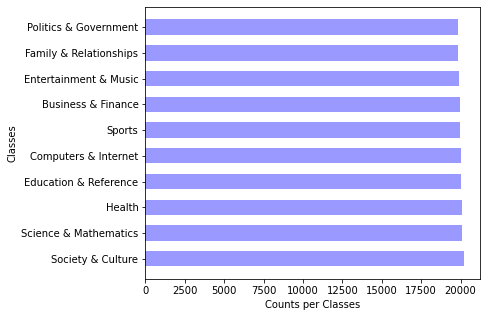

In [11]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [12]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [13]:
lst_stopwords = stopwords.words('english')

In [14]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [15]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [16]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
1123646,9,What do you think of my approach?,"Hey I saw you last Thursday. ""She blushes"" Why...",LOL a little pushy...nahh but its ok though sh...,What do you think of my approach?Hey I saw you...,What do you think of my approach?Hey I saw you...,think approach hey saw last thursday blush sit...
90949,3,where can I get free vicodin?,,"If you are addicted to it, and you probably kn...",where can I get free vicodin?,where can I get free vicodin?If you are addict...,get free vicodin addicted probably know narcot...
258652,9,questions for the guys only.... what is more i...,"in a girl's physique, nice ass or big breast ....",In all seriousness...will you be worrying abou...,questions for the guys only.... what is more i...,questions for the guys only.... what is more i...,question guy important girl physique nice as b...
1022785,7,I Need help in finding mortgage lenders of PRC...,Lower part of the house is built of concrete a...,Just phone up any mortgage company and ask the...,I Need help in finding mortgage lenders of PRC...,I Need help in finding mortgage lenders of PRC...,need help finding mortgage lender prc home aka...
1335994,4,What's the origin of Gobsmacked?,I've looked it up and all I can find is that i...,everyone else has a better answer than me but ...,What's the origin of Gobsmacked?I've looked it...,What's the origin of Gobsmacked?I've looked it...,origin gobsmacked looked find variation flabbe...
132725,1,"whenever I check the time, most of the time, i...",superstition,It depends. What are you doing when you check ...,"whenever I check the time, most of the time, i...","whenever I check the time, most of the time, i...",whenever check time time mean superstitionit d...
670217,6,who got hurt in the buffalo vs carolina game y...,"someone hurt something, just cant remember","Teppo Numminen in the first period with a ""low...",who got hurt in the buffalo vs carolina game y...,who got hurt in the buffalo vs carolina game y...,got hurt buffalo v carolina game yesterday som...
1056276,4,What are some easy to learn short christmas so...,I work at a preschool and we will be having th...,Check out this web site they have lots of litt...,What are some easy to learn short christmas so...,What are some easy to learn short christmas so...,easy learn short christmas song work preschool...
1209440,4,According to Celestine N. Bittle what is the d...,Celestine N. Bittle is a philosopher but Im ha...,I also could not find anything on the web. try...,According to Celestine N. Bittle what is the d...,According to Celestine N. Bittle what is the d...,according celestine n bittle definition logic ...
683919,6,who's the best football striker?,european league,Ronaldinho,who's the best football striker?european league,who's the best football striker?european leagu...,best football striker european leagueronaldinho


In [17]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [18]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
1123646,9,What do you think of my approach?,"Hey I saw you last Thursday. ""She blushes"" Why...",LOL a little pushy...nahh but its ok though sh...,What do you think of my approach?Hey I saw you...,What do you think of my approach?Hey I saw you...,think approach hey saw last thursday blush sit...,75,317,15,4.226667,5.0
90949,3,where can I get free vicodin?,,"If you are addicted to it, and you probably kn...",where can I get free vicodin?,where can I get free vicodin?If you are addict...,get free vicodin addicted probably know narcot...,66,275,5,4.166667,13.2


In [19]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

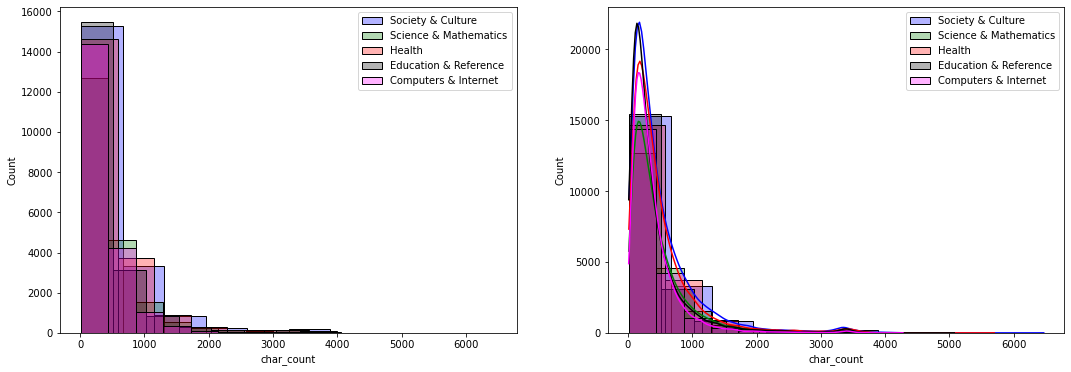

In [20]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [21]:
df.groupby('target').word_count.median()

target
1     71
2     66
3     75
4     52
5     60
6     45
7     52
8     41
9     75
10    72
Name: word_count, dtype: int64

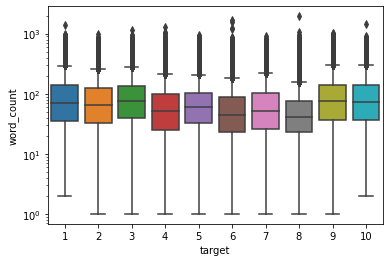

In [22]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

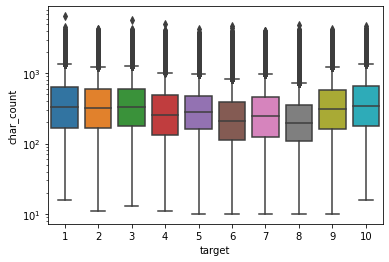

In [23]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

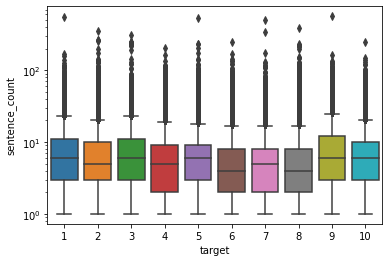

In [24]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

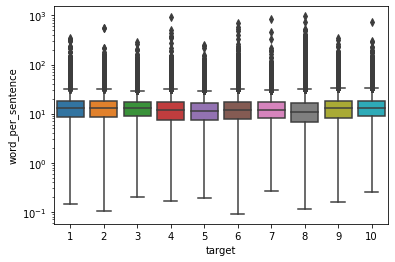

In [25]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [26]:
X = df.Text_new
y = df.target

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [28]:
vect = TfidfVectorizer(max_features=5000,ngram_range=(1,2))

In [29]:
XX_train = vect.fit_transform(X_train)

In [30]:
XX_test = vect.fit_transform(X_test)

In [31]:
vocab = vect.vocabulary_

In [32]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [33]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

4753

In [34]:
df_features.head(5)

,feature,Score,y
82,ad,1.0,1
142,allergy,1.0,1
189,andup andup,1.0,1
261,approach,1.0,1
310,associate,1.0,1


In [35]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 1695
ad,allergy,andup andup,approach,associate,believe,believe god,believed,bell,belly,big,big bang,bit,bitter,blame,blank,bleeding,castle,cat,caused,chill,chosen,chris,christ,christian,chronic,colony,come,complication,created

category 2: Science & Mathematics
length of category 2: 2594
4th,5th,6th,80,accent,achieve,aint,alien,amount,analysis,anger,angry,answered question,assuming,astronaut,ate,aware,bachelor,bar,bay,best friend,bigger,billy,bio,bite,budget,cable,caesar,cal,car

category 3: Health
length of category 3: 2355
aa,abortion,acid,affair,algebra,allow,allowed,animal,answering question,anti,apple,area,assistance,automatically,available,bachelor,back,basket,becoming,ben,biology,bipolar,bird,birthday,black hole,blair,blocked,blog,blowing,bob

category 4: Education & Reference
length of category 4: 1390
5th,academy,administrator,around,asks,audio,awhile,bomb,camera,civilian,class,coffee,commonly,courage,definitely,diameter,digi

In [36]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [37]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(180000, 4753)

In [38]:
XX_test = vect.transform(X_test)

In [39]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [40]:
# Creating a cloud of words

In [41]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [42]:
Text = " ".join(df_features[df_features.y==6].feature[:30])
Text

'april army associated attorney au badly bare basic basis bean beside best friend billion bored bottom line bound brace capacity cause ce cfm chain checking chest chinese closest clue compared complication condition'

In [43]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

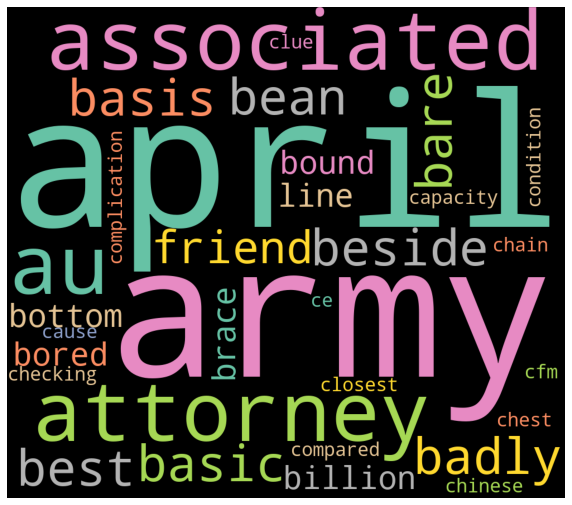

In [44]:
plot_cloud(wordcloud)

In [45]:
cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [46]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [47]:
nb = naive_bayes.MultinomialNB()

In [48]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [49]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6584611111111112

In [50]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [51]:
## Test Classifier
Predicted = nb.predict(XX_test)
Predicted_prob = nb.predict_proba(XX_test)

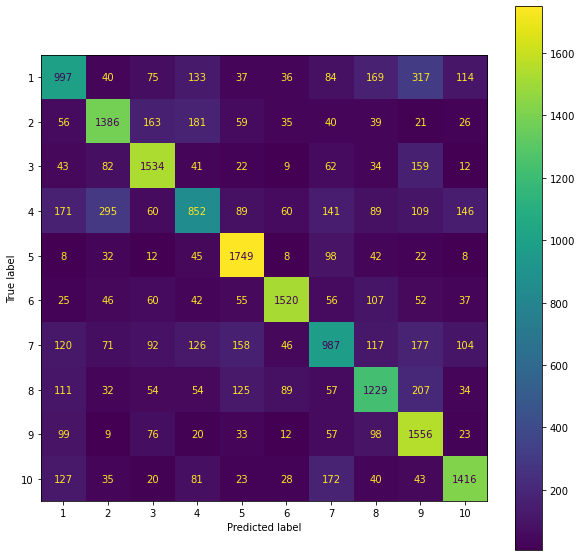

In [52]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

In [53]:
cross_val_score(nb,X_train_cvec,y_train,cv=5,n_jobs=-1).mean()

0.6572944444444444

### Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [54]:
model_lr = LogisticRegression(max_iter=5000)

In [55]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [56]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6715444444444445

In [57]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000)

In [58]:
## Test Classifier
Predicted = model_lr.predict(XX_test)
Predicted_prob = model_lr.predict_proba(XX_test)

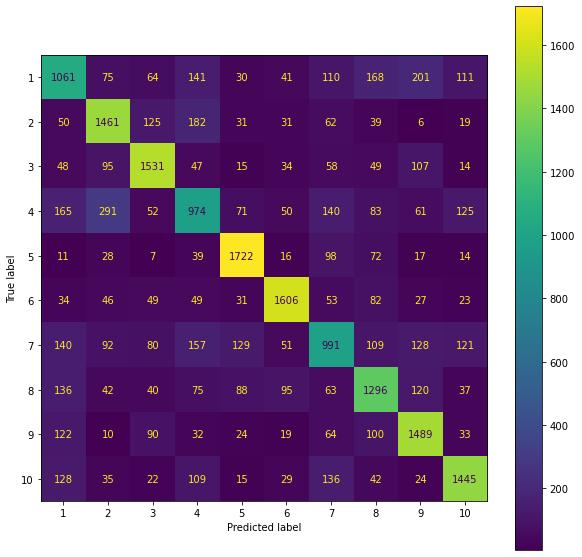

In [64]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

### Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [65]:
model_rf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)

In [61]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [62]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1)

KeyboardInterrupt: 

In [66]:
model_rf.fit(XX_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [67]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

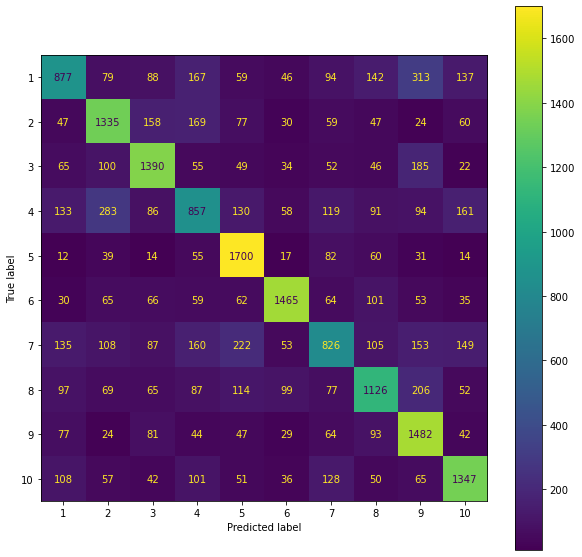

In [68]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

In [69]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

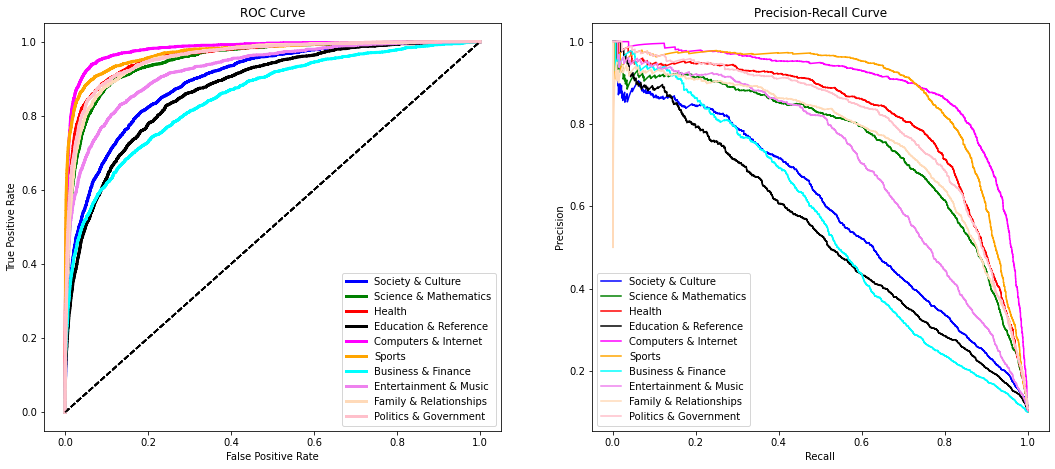

In [70]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()
    

### USE THE BELOW LINES FOR DEBUGGING

In [71]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [153]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

Int64Index([  95362,  202304,  277183,  287137,   71496,  320049,  172397,
             200175,  313562,   62539,
            ...
             130559, 1216462,  203866,   20497,  132491,  157082,  310700,
              90773,  756179,   57504],
           dtype='int64', length=1007)

In [169]:
test_set = 51
text = X_test.iloc[test_set]
text

'b f graduating grad school weekend good gift idea want get something expensive get someone graduating college really liked getting set tool might check hot book field study could useful next step'

In [170]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

Actual class --> Family & Relationships
Predicted class --> Education & Reference


In [171]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [172]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=3,top_labels=1)

In [150]:
explained.show_in_notebook(text=text,predict_proba=True)

In [175]:
gg = model_lr.predict(XX_train)

In [178]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train

Int64Index([   3121,    4576,  102311, 1341619,  295880,  853900,  378103,
             242582,   49900,    3902,
            ...
             603532,   38772,  478612,   87206,  126108,   41648,  210022,
             120238,  168790,  211121],
           dtype='int64', length=8764)

In [184]:
df.loc[3121]['Q&A']

"I need to do a easy fast science fair project or I'll flunk my class can yall plz help me?Make a sweet model of the solar system with different fruits!  Then at least you won't be hungry after you fail =)"

In [ ]:
g = df[df.target==7]
g.head()

In [ ]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)